<div style="display:block;width:100%;margin:auto;" direction=rtl align=center><br><br>
    <div  style="width:100%;margin:100;display:block;background-color:#fff0;"  display=block align=center>
        <table style="border-style:hidden;border-collapse:collapse;">
            <tr>
                <td  style="border: none!important;">
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
                </td>
                <td style="text-align:center;border: none!important;">
                <h1 align=center><font size=5 color="#045F5F"> <b>Deep Learning (Fall 2023)</b><br><br><b>Homework-1</i><br><br><h1><h3>Multi-Layer Perceptron-Q4</i></font></h3>
                </td>
                <td style="border: none!important;">
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
                </td>
            </tr>
        </table>
    
</div>
<br>
<font size=3 color="#045F5F">Mohammad Javad Ranjbar<br></font><br>
<font size=3 color="#045F5F">Behrad Mosaie<br></font><br>

# Required Libraries
In this code cell, we set up the necessary libraries and dependencies for knowledge distillation using a neural network. We import key libraries, including PyTorch, torchvision, and additional modules for data transformation, visualization, and progress tracking. Make sure to run this cell before proceeding with the rest of the code.



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # Import tqdm

# 1-4) Pre-processing

## A
In this code cell, we begin by downloading the MNIST dataset, which is a popular dataset for digit recognition. We also define a transformation for preprocessing the data, which converts the images into tensors. The code then downloads both the training and testing datasets.

This code cell downloads the MNIST dataset and provides information about the number of samples in the training and testing sets, as well as the size of the first image in the datasets.

In [2]:
# Step 2: Download the MNIST dataset
# Define a transform to preprocess the data
transform = transforms.Compose([transforms.ToTensor()])

# Download the training and testing datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, )
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)
print(f"There is {len(trainset)} samples in the trainset with sizs of {trainset[0][0].size}" )
print(f"There is {len(testset)} samples in the testset with sizs of {testset[0][0].size}" )
print(f"Also we split validationset for evaluation. There is {int(len(testset)*20/100)} samples in the valset with sizs of {trainset[0][0].size}" )

100%|██████████| 9912422/9912422 [00:00<00:00, 102538853.72it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 116253065.09it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 125013853.63it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 22518355.52it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

There is 60000 samples in the trainset with sizs of (28, 28)
There is 10000 samples in the testset with sizs of (28, 28)
Also we split validationset for evaluation. There is 2000 samples in the valset with sizs of (28, 28)


## B
In this code cell, we define a function show_random_images that displays random images from each class in the MNIST dataset. We create a dictionary to store images for each class and then plot a random image from each class.
This code cell defines a function to display random images from the MNIST dataset, and then it shows these images for each of the 10 classes (digits 0 to 9).

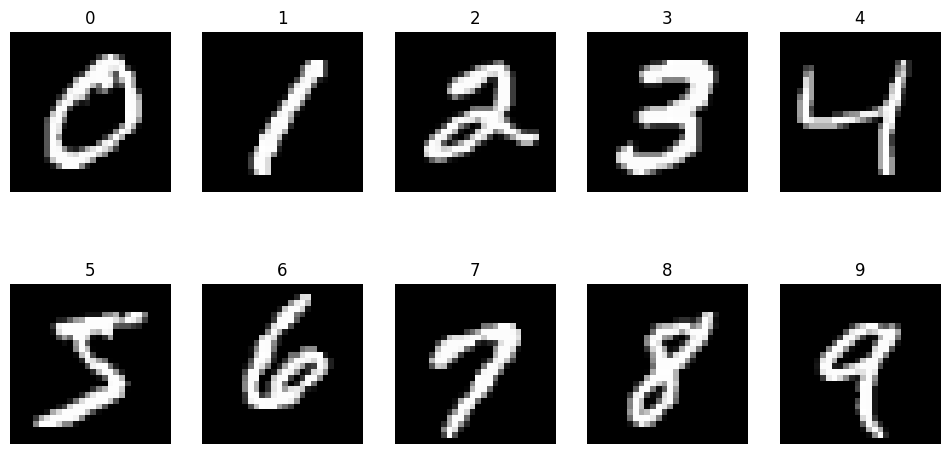

In [3]:
def show_random_images(dataset, classes):
    class_to_images = {}  # Create a dictionary to store images for each class
    for i in range(len(dataset)):
        image, label = dataset[i]
        if label not in class_to_images:
            class_to_images[label] = image

    # Plot a random image from each class
    plt.figure(figsize=(12, 6))
    for label, image in class_to_images.items():
        plt.subplot(2, 5, label + 1)
        plt.title(classes[label])
        plt.imshow(np.array(image), cmap='gray')
        plt.axis('off')
    plt.show()
# Define class names for MNIST (0-9 digits)
classes = list(map(str, range(10)))

# Show random images from each class
show_random_images(trainset, classes)

## C
In this code cell, we define a function plot_histogram to create histograms showing the class distribution in the training and testing datasets. It counts the number of samples for each class and then plots a bar chart to visualize the distribution.

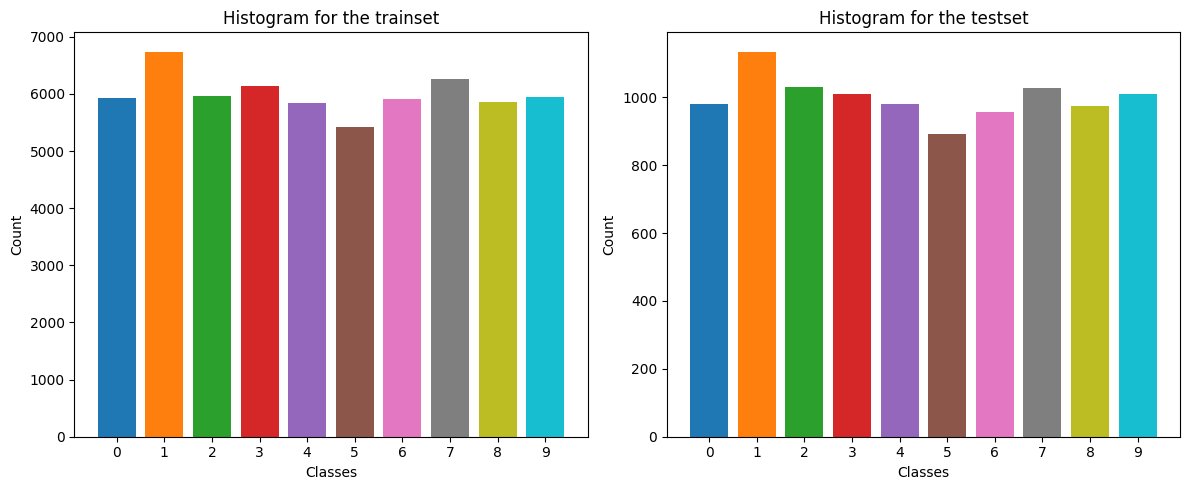

In [4]:
import matplotlib.pyplot as plt

num_classes = 10

def plot_histogram(dataset, title, subplot_position):
    class_counts = [0] * num_classes
    for _, label in dataset:
        class_counts[label] += 1

    colors = plt.cm.tab10(range(num_classes))

    # Create a subplot with 1 row and 2 columns
    plt.subplot(1, 2, subplot_position)
    plt.bar(range(num_classes), class_counts, color=colors)
    plt.xticks(range(num_classes), [str(i) for i in range(num_classes)])
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title(title)

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Call the plot_histogram function for both trainset and testset
plot_histogram(trainset, "Histogram for the trainset", 1)
plot_histogram(testset, "Histogram for the testset", 2)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


## D) Min-max normalization
In this code cell, we perform preprocessing on the dataset and create DataLoaders for training, validation, and testing. The steps include normalizing the data, splitting it into training and validation sets, and creating DataLoaders for efficient batch processing.

In [5]:
min_value = torch.min(trainset.data.to(dtype=torch.float32))
max_value = torch.max(trainset.data.to(dtype=torch.float32))

# Define a function to normalize the data to the range [0, 1]
def min_max_normalize(data):
    return (data - min_value.numpy()) / (max_value.numpy() - min_value.numpy())


# Step 3: Preprocess the dataset and create DataLoaders
batch_size = 32

normalized_trainset = [(min_max_normalize(torch.tensor(np.array(image))), label) for image, label in trainset]
normalized_testset = [(min_max_normalize(torch.tensor(np.array(image))), label) for image, label in testset]

#Create validationset

trainset_size = int(0.8 * len(normalized_trainset))  # 80% for training
valset_size = len(normalized_trainset) - trainset_size  # 20% for validation
trainset, valset = torch.utils.data.random_split(normalized_trainset, [trainset_size, valset_size])

# Create DataLoaders



# Create DataLoaders for training, validation, and testing
trainloader = torch.utils.data.DataLoader(normalized_trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(normalized_testset, batch_size=batch_size, shuffle=False)


# Teacher Network
In this code cell, we define a PyTorch neural network class called TeacherNetwork that serves as the teacher model. The teacher network consists of three fully connected layers with ReLU activation functions. The architecture is defined with the specified input size and hidden layer sizes.

In [6]:
class TeacherNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(TeacherNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 10)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

input_size = 784
hidden_size1 = 1024
hidden_size2 = 512

teacher_network = TeacherNetwork(input_size, hidden_size1, hidden_size2)

print(teacher_network)


TeacherNetwork(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


### Training and evaluation Function for Neural Networks
In this code cell, we define a training, evaluation and plot_loss_and_accuracy function for neural networks. Train function trains the provided model using the training data, evaluates it on the validation data, and records the loss and accuracy during each epoch.
The evaluation function evaluates the provided model on a given data loader (e.g., validation or test data) and computes the accuracy and average loss.italicized text
plot_loss_and_accuracy allows you to create two subplots: one for loss values and another for accuracy values. You can use this function to visualize the training and validation loss as well as the training and validation accuracy over epochs.

In [7]:

def train(model, train_loader,test_loader, criterion, optimizer, num_epochs):
    model.train()  # Set the model to training mode

    loss_history = {'train': [], 'test': []}
    accuracy_history = {'train': [], 'test': []}

    for epoch in range(num_epochs):
        running_loss = 0.0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc=f'Epoch [{epoch + 1}/{num_epochs}] (Training)'):
            # Forward pass
            outputs = model(inputs.view(-1, 784))

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate training accuracy and loss
        train_accuracy, train_loss = evaluate(model, train_loader, criterion)
        loss_history['train'].append(train_loss)
        accuracy_history['train'].append(train_accuracy)

        # Calculate validation (test) accuracy and loss
        test_accuracy, test_loss = evaluate(model, test_loader, criterion)
        loss_history['test'].append(test_loss)
        accuracy_history['test'].append(test_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}]. Training Loss: {train_loss:.4f}. Training Accuracy: {train_accuracy:.2f}%. Validation Loss: {test_loss:.4f}. Validation Accuracy: {test_accuracy:.2f}%')

        #print(f'Epoch [{epoch + 1}/{num_epochs}] (Validation): Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

    print('Training and validation complete.')
    return loss_history,accuracy_history,model

def evaluate(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs.view(-1, 784))
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    accuracy = 100 * correct / total
    return accuracy, running_loss / len(data_loader)
def plot_loss_and_accuracy(loss_history, accuracy_history):
    epochs = len(loss_history['train'])
    x = np.arange(1, epochs + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(x, loss_history['train'], label='Training Loss')
    plt.plot(x, loss_history['test'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(x, accuracy_history['train'], label='Training Accuracy')
    plt.plot(x, accuracy_history['test'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

In this code cell, we create an instance of the TeacherNetwork, specify hyperparameters like the number of epochs and batch size, define the loss criterion and optimizer, and then train the teacher network using the provided training and validation data loaders.

In [8]:
input_size = 784
hidden_size1 = 1024
hidden_size2 = 512

teacher_network = TeacherNetwork(input_size, hidden_size1, hidden_size2)

num_epochs = 20
batch_size = 32

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher_network.parameters(), lr=0.01)
accuracy_list,loss_list,teacher_network=train(teacher_network,trainloader,valloader,criterion,optimizer,num_epochs)

Epoch [1/20] (Training): 100%|██████████| 1875/1875 [00:12<00:00, 152.88it/s]


Epoch [1/20]. Training Loss: 0.4030. Training Accuracy: 88.65%. Validation Loss: 0.4057. Validation Accuracy: 88.48%


Epoch [2/20] (Training): 100%|██████████| 1875/1875 [00:08<00:00, 209.06it/s]


Epoch [2/20]. Training Loss: 0.3047. Training Accuracy: 91.22%. Validation Loss: 0.3031. Validation Accuracy: 91.14%


Epoch [3/20] (Training): 100%|██████████| 1875/1875 [00:08<00:00, 210.15it/s]


Epoch [3/20]. Training Loss: 0.2653. Training Accuracy: 92.33%. Validation Loss: 0.2634. Validation Accuracy: 92.29%


Epoch [4/20] (Training): 100%|██████████| 1875/1875 [00:08<00:00, 208.75it/s]


Epoch [4/20]. Training Loss: 0.2372. Training Accuracy: 93.10%. Validation Loss: 0.2359. Validation Accuracy: 93.03%


Epoch [5/20] (Training): 100%|██████████| 1875/1875 [00:09<00:00, 207.74it/s]


Epoch [5/20]. Training Loss: 0.1953. Training Accuracy: 94.52%. Validation Loss: 0.1951. Validation Accuracy: 94.38%


Epoch [6/20] (Training): 100%|██████████| 1875/1875 [00:10<00:00, 181.63it/s]


Epoch [6/20]. Training Loss: 0.1770. Training Accuracy: 94.88%. Validation Loss: 0.1773. Validation Accuracy: 94.82%


Epoch [7/20] (Training): 100%|██████████| 1875/1875 [00:08<00:00, 211.16it/s]


Epoch [7/20]. Training Loss: 0.1555. Training Accuracy: 95.53%. Validation Loss: 0.1544. Validation Accuracy: 95.45%


Epoch [8/20] (Training): 100%|██████████| 1875/1875 [00:09<00:00, 198.82it/s]


Epoch [8/20]. Training Loss: 0.1376. Training Accuracy: 96.17%. Validation Loss: 0.1390. Validation Accuracy: 96.03%


Epoch [9/20] (Training): 100%|██████████| 1875/1875 [00:14<00:00, 127.10it/s]


Epoch [9/20]. Training Loss: 0.1236. Training Accuracy: 96.53%. Validation Loss: 0.1239. Validation Accuracy: 96.42%


Epoch [10/20] (Training): 100%|██████████| 1875/1875 [00:12<00:00, 150.57it/s]


Epoch [10/20]. Training Loss: 0.1131. Training Accuracy: 96.81%. Validation Loss: 0.1132. Validation Accuracy: 96.77%


Epoch [11/20] (Training): 100%|██████████| 1875/1875 [00:08<00:00, 210.14it/s]


Epoch [11/20]. Training Loss: 0.1071. Training Accuracy: 97.00%. Validation Loss: 0.1073. Validation Accuracy: 97.06%


Epoch [12/20] (Training): 100%|██████████| 1875/1875 [00:08<00:00, 209.22it/s]


Epoch [12/20]. Training Loss: 0.0953. Training Accuracy: 97.36%. Validation Loss: 0.0961. Validation Accuracy: 97.27%


Epoch [13/20] (Training): 100%|██████████| 1875/1875 [00:08<00:00, 210.04it/s]


Epoch [13/20]. Training Loss: 0.0894. Training Accuracy: 97.47%. Validation Loss: 0.0900. Validation Accuracy: 97.38%


Epoch [14/20] (Training): 100%|██████████| 1875/1875 [00:08<00:00, 212.09it/s]


Epoch [14/20]. Training Loss: 0.0812. Training Accuracy: 97.73%. Validation Loss: 0.0808. Validation Accuracy: 97.78%


Epoch [15/20] (Training): 100%|██████████| 1875/1875 [00:09<00:00, 206.55it/s]


Epoch [15/20]. Training Loss: 0.0738. Training Accuracy: 97.98%. Validation Loss: 0.0740. Validation Accuracy: 98.00%


Epoch [16/20] (Training): 100%|██████████| 1875/1875 [00:09<00:00, 207.91it/s]


Epoch [16/20]. Training Loss: 0.0696. Training Accuracy: 98.11%. Validation Loss: 0.0689. Validation Accuracy: 98.12%


Epoch [17/20] (Training): 100%|██████████| 1875/1875 [00:08<00:00, 212.03it/s]


Epoch [17/20]. Training Loss: 0.0639. Training Accuracy: 98.27%. Validation Loss: 0.0643. Validation Accuracy: 98.19%


Epoch [18/20] (Training): 100%|██████████| 1875/1875 [00:08<00:00, 213.78it/s]


Epoch [18/20]. Training Loss: 0.0598. Training Accuracy: 98.39%. Validation Loss: 0.0593. Validation Accuracy: 98.38%


Epoch [19/20] (Training): 100%|██████████| 1875/1875 [00:08<00:00, 217.68it/s]


Epoch [19/20]. Training Loss: 0.0548. Training Accuracy: 98.55%. Validation Loss: 0.0555. Validation Accuracy: 98.58%


Epoch [20/20] (Training): 100%|██████████| 1875/1875 [00:12<00:00, 147.79it/s]


Epoch [20/20]. Training Loss: 0.0511. Training Accuracy: 98.64%. Validation Loss: 0.0517. Validation Accuracy: 98.59%
Training and validation complete.


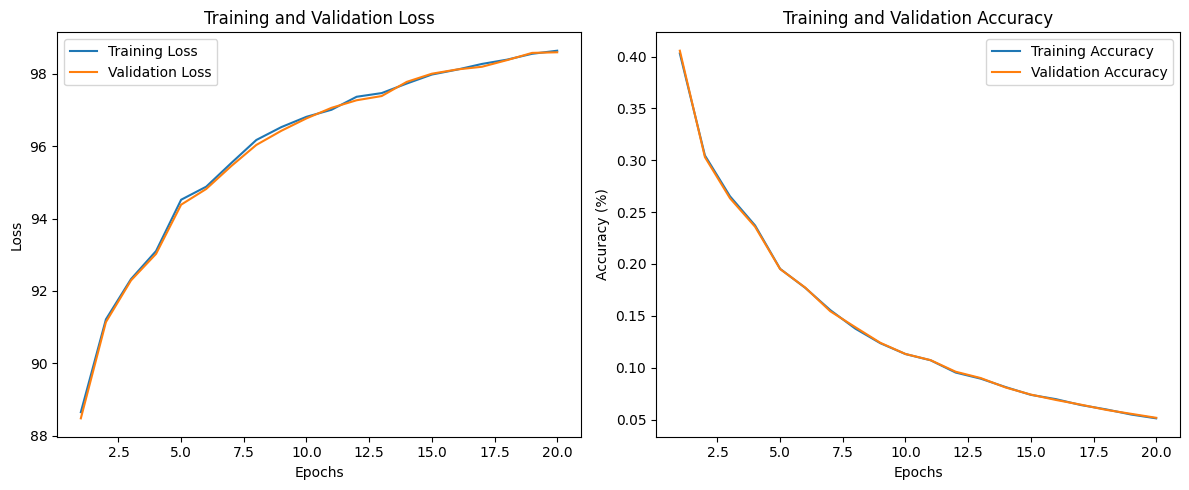

In [9]:
plot_loss_and_accuracy(loss_list, accuracy_list)

In this code cell, we define a generalized accuracy calculator function that can be used to evaluate the performance of a neural network model on a given data loader. The function calculates accuracy, misclassifications, and provides predictions and true labels.

In [10]:
def accuracy_calculator(NN_Model,dataloader):
  NN_Model.eval()
  correct = 0
  total = 0
  misclassifications = 0
  predication=[]
  true_labels=[]
  with torch.no_grad():
      for data in dataloader:
          inputs, labels = data
          inputs = inputs.view(-1, input_size)
          outputs = NN_Model(inputs)
          _, predicted = torch.max(outputs, 1)
          predication.extend(predicted.tolist())
          true_labels.extend(labels.tolist())
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          misclassifications += (predicted != labels).sum().item()

  accuracy_test = 100 * correct / total

  return accuracy_test,misclassifications,predication,true_labels

In [11]:
accuracy_train,misclassifications_train,train_predication, true_train_labels= accuracy_calculator(teacher_network,trainloader)
print(f'Accuracy on train data: {accuracy_train:.2f}%')
print(f'Misclassifications on train data: {misclassifications_train}')
accuracy_test,misclassifications_test,test_predication, true_test_labels= accuracy_calculator(teacher_network,testloader)
print(f'Accuracy on test data: {accuracy_test:.2f}%')
print(f'Misclassifications on test data: {misclassifications_test}')

Accuracy on train data: 98.64%
Misclassifications on train data: 819
Accuracy on test data: 97.63%
Misclassifications on test data: 237


The code provided defines a function conf_matrix that is used to create and visualize confusion matrices for both training and test datasets. It relies on libraries like scikit-learn for confusion matrix calculation and seaborn for heatmap visualization. Below is the code with comments explaining its functionality:



In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
def conf_matrix(true_train_labels,train_predication,true_test_labels,test_predication):
  # Make sure you have predictions for both the training and test datasets
  # Assuming you have 'train_predictions' and 'test_predictions'

  # Create a confusion matrix for the training data
  train_confusion_matrix = confusion_matrix(true_train_labels, train_predication)

  # Create a confusion matrix for the test data
  test_confusion_matrix = confusion_matrix(true_test_labels, test_predication)

  # Plot the confusion matrices
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  sns.heatmap(train_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix - Training Data')

  plt.subplot(1, 2, 2)
  sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix - Test Data')

  plt.show()


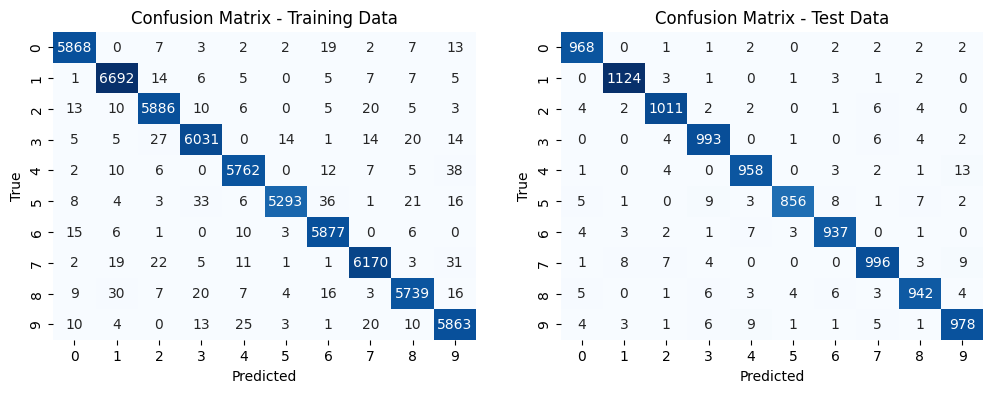

In [13]:
conf_matrix(true_train_labels,train_predication,true_test_labels,test_predication)

## Student Netowrk

In this code cell, we define a PyTorch neural network class called StudentNetwork. This class represents the student model in a knowledge distillation setup. The student network architecture includes three fully connected layers with ReLU activation functions.

In [14]:
class StudentNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(StudentNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 10)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out


input_size = 784
hidden_size1 = 128
hidden_size2 = 64
student_network = StudentNetwork(input_size, hidden_size1, hidden_size2)

print(student_network)


StudentNetwork(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [15]:
num_epochs = 10
batch_size = 32
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(student_network.parameters(), lr=0.01)
accuracy_list,loss_list,student_network=train(student_network,trainloader,trainloader,criterion,optimizer,num_epochs)

Epoch [1/10] (Training): 100%|██████████| 1875/1875 [00:06<00:00, 271.80it/s]


Epoch [1/10]. Training Loss: 0.4281. Training Accuracy: 88.25%. Validation Loss: 0.4281. Validation Accuracy: 88.25%


Epoch [2/10] (Training): 100%|██████████| 1875/1875 [00:02<00:00, 685.65it/s]


Epoch [2/10]. Training Loss: 0.3304. Training Accuracy: 90.61%. Validation Loss: 0.3304. Validation Accuracy: 90.61%


Epoch [3/10] (Training): 100%|██████████| 1875/1875 [00:02<00:00, 702.69it/s]


Epoch [3/10]. Training Loss: 0.2898. Training Accuracy: 91.65%. Validation Loss: 0.2898. Validation Accuracy: 91.65%


Epoch [4/10] (Training): 100%|██████████| 1875/1875 [00:02<00:00, 716.31it/s]


Epoch [4/10]. Training Loss: 0.2557. Training Accuracy: 92.64%. Validation Loss: 0.2557. Validation Accuracy: 92.64%


Epoch [5/10] (Training): 100%|██████████| 1875/1875 [00:03<00:00, 582.30it/s]


Epoch [5/10]. Training Loss: 0.2248. Training Accuracy: 93.65%. Validation Loss: 0.2248. Validation Accuracy: 93.65%


Epoch [6/10] (Training): 100%|██████████| 1875/1875 [00:02<00:00, 727.46it/s]


Epoch [6/10]. Training Loss: 0.2000. Training Accuracy: 94.31%. Validation Loss: 0.2000. Validation Accuracy: 94.31%


Epoch [7/10] (Training): 100%|██████████| 1875/1875 [00:02<00:00, 625.24it/s]


Epoch [7/10]. Training Loss: 0.1809. Training Accuracy: 94.86%. Validation Loss: 0.1809. Validation Accuracy: 94.86%


Epoch [8/10] (Training): 100%|██████████| 1875/1875 [00:02<00:00, 701.56it/s]


Epoch [8/10]. Training Loss: 0.1675. Training Accuracy: 95.21%. Validation Loss: 0.1675. Validation Accuracy: 95.21%


Epoch [9/10] (Training): 100%|██████████| 1875/1875 [00:02<00:00, 703.09it/s]


Epoch [9/10]. Training Loss: 0.1509. Training Accuracy: 95.75%. Validation Loss: 0.1509. Validation Accuracy: 95.75%


Epoch [10/10] (Training): 100%|██████████| 1875/1875 [00:02<00:00, 645.26it/s]


Epoch [10/10]. Training Loss: 0.1359. Training Accuracy: 96.16%. Validation Loss: 0.1359. Validation Accuracy: 96.16%
Training and validation complete.


In this code cell, accuracy and misclassifications are calculated for both the student network on the training data and the teacher network on the test data. The results are printed to assess the performance of the networks. Here's a text cell describing this code:

In [17]:
accuracy_train,misclassifications_train,train_predication, true_train_labels= accuracy_calculator(student_network,trainloader)
print(f'Accuracy on train data: {accuracy_train:.2f}%')
print(f'Misclassifications on train data: {misclassifications_train}')
accuracy_test,misclassifications_test,test_predication, true_test_labels= accuracy_calculator(student_network,testloader)
print(f'Accuracy on test data: {accuracy_test:.2f}%')
print(f'Misclassifications on test data: {misclassifications_test}')

Accuracy on train data: 96.16%
Misclassifications on train data: 2306
Accuracy on test data: 97.63%
Misclassifications on test data: 237


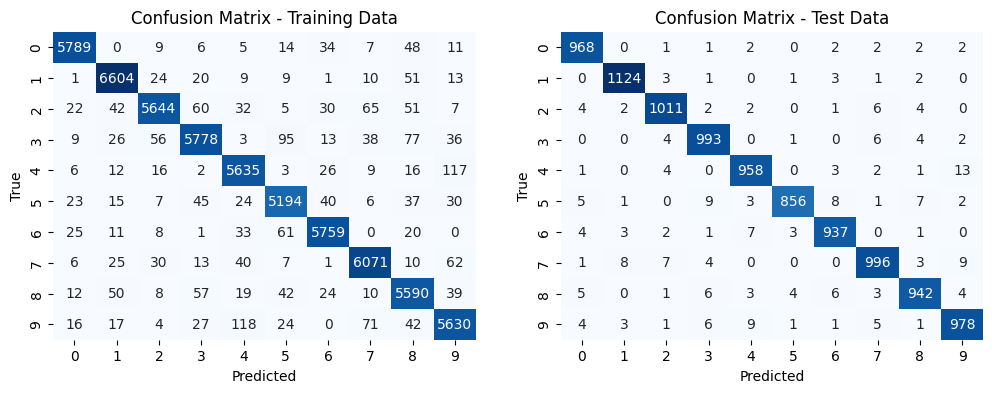

In [18]:
conf_matrix(true_train_labels,train_predication,true_test_labels,test_predication)

# 4-4) Knowledge Distillation

In this code cell, a function Knowledge_Distillation is defined to perform knowledge distillation from a teacher model to a student model. The code also includes a custom evaluation function called evaluate_distilled_model. Here's a text cell describing this code:

In [21]:
from tqdm import tqdm
def Knowledge_Distillation(teacher_model,student_model, train_loader,test_loader, criterion, optimizer, num_epochs):
    student_model.train()  # Set the model to training mode
    teacher_model.eval()
    loss_history = {'train': [], 'test': []}
    accuracy_history = {'train': [], 'test': []}

    for epoch in range(num_epochs):
        running_loss = 0.0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc=f'Epoch [{epoch + 1}/{num_epochs}] (Training)'):
            # Forward pass
            outputs = student_model(inputs.view(-1, 784))
            labels = teacher_model(inputs.view(-1, 784))
            # Compute the loss
            loss = criterion(outputs, labels)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate training accuracy and loss
        train_accuracy, train_loss = evaluate_distiled_model(student_model, train_loader, criterion)
        loss_history['train'].append(train_loss)
        accuracy_history['train'].append(train_accuracy)

        # Calculate validation (test) accuracy and loss
        test_accuracy, test_loss = evaluate_distiled_model(student_model, test_loader, criterion)
        loss_history['test'].append(test_loss)
        accuracy_history['test'].append(test_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}]. Training Loss: {train_loss:.4f}. Training Accuracy: {train_accuracy:.2f}%. Validation Loss: {test_loss:.4f}. Validation Accuracy: {test_accuracy:.2f}%')

        #print(f'Epoch [{epoch + 1}/{num_epochs}] (Validation): Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

    print('Training and validation complete.')
    return loss_history,accuracy_history,student_model
def evaluate_distiled_model(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs.view(-1, 784))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(predicted, labels.float())
            running_loss += loss.item()

    accuracy = 100 * correct / total
    return accuracy, running_loss / len(data_loader)

In this code cell, knowledge distillation is performed to train a student network using a teacher network as the source of knowledge. The student network is optimized to mimic the teacher's predictions.



In [22]:
num_epochs = 10
criterion = nn.MSELoss()
input_size = 784
hidden_size1 = 128
hidden_size2 = 64
student_network = StudentNetwork(input_size, hidden_size1, hidden_size2)
optimizer = optim.SGD(student_network.parameters(), lr=0.01)
accuracy_list_KD,loss_list_KD,student_network=Knowledge_Distillation(teacher_network,student_network,trainloader,trainloader,criterion,optimizer,num_epochs)

Epoch [1/10] (Training): 100%|██████████| 1875/1875 [00:12<00:00, 151.31it/s]


Epoch [1/10]. Training Loss: 0.8588. Training Accuracy: 95.11%. Validation Loss: 0.8588. Validation Accuracy: 95.11%


Epoch [2/10] (Training): 100%|██████████| 1875/1875 [00:10<00:00, 183.25it/s]


Epoch [2/10]. Training Loss: 0.6329. Training Accuracy: 96.50%. Validation Loss: 0.6329. Validation Accuracy: 96.50%


Epoch [3/10] (Training): 100%|██████████| 1875/1875 [00:12<00:00, 154.53it/s]


Epoch [3/10]. Training Loss: 0.5461. Training Accuracy: 96.97%. Validation Loss: 0.5461. Validation Accuracy: 96.97%


Epoch [4/10] (Training): 100%|██████████| 1875/1875 [00:10<00:00, 186.83it/s]


Epoch [4/10]. Training Loss: 0.4928. Training Accuracy: 97.21%. Validation Loss: 0.4928. Validation Accuracy: 97.21%


Epoch [5/10] (Training): 100%|██████████| 1875/1875 [00:10<00:00, 184.55it/s]


Epoch [5/10]. Training Loss: 0.4599. Training Accuracy: 97.46%. Validation Loss: 0.4599. Validation Accuracy: 97.46%


Epoch [6/10] (Training): 100%|██████████| 1875/1875 [00:11<00:00, 162.37it/s]


Epoch [6/10]. Training Loss: 0.4455. Training Accuracy: 97.53%. Validation Loss: 0.4455. Validation Accuracy: 97.53%


Epoch [7/10] (Training): 100%|██████████| 1875/1875 [00:11<00:00, 169.25it/s]


Epoch [7/10]. Training Loss: 0.4386. Training Accuracy: 97.58%. Validation Loss: 0.4386. Validation Accuracy: 97.58%


Epoch [8/10] (Training): 100%|██████████| 1875/1875 [00:15<00:00, 120.30it/s]


Epoch [8/10]. Training Loss: 0.4250. Training Accuracy: 97.63%. Validation Loss: 0.4250. Validation Accuracy: 97.63%


Epoch [9/10] (Training): 100%|██████████| 1875/1875 [00:14<00:00, 129.52it/s]


Epoch [9/10]. Training Loss: 0.4163. Training Accuracy: 97.75%. Validation Loss: 0.4163. Validation Accuracy: 97.75%


Epoch [10/10] (Training): 100%|██████████| 1875/1875 [00:10<00:00, 182.82it/s]


Epoch [10/10]. Training Loss: 0.4104. Training Accuracy: 97.76%. Validation Loss: 0.4104. Validation Accuracy: 97.76%
Training and validation complete.


## A
In this code cell, you are evaluating the performance of the student network on both the training and test datasets. You calculate accuracy and misclassifications, providing insights into how well the model has learned.

In [23]:
accuracy_train,misclassifications_train,train_predication, true_train_labels= accuracy_calculator(student_network,trainloader)
print(f'Accuracy on train data: {accuracy_train:.2f}%')
print(f'Misclassifications on train data: {misclassifications_train}')
accuracy_test,misclassifications_test,test_predication, true_test_labels= accuracy_calculator(student_network,testloader)
print(f'Accuracy on test data: {accuracy_test:.2f}%')
print(f'Misclassifications on test data: {misclassifications_test}')

Accuracy on train data: 97.76%
Misclassifications on train data: 1342
Accuracy on test data: 97.12%
Misclassifications on test data: 288


## B

This code generates a comparison plot of loss values for "Model 1" and "Model 2" over multiple epochs. The graph helps visualize how the accuracy of the two models change during training. The legend and grid lines are added for clarity in the plot.

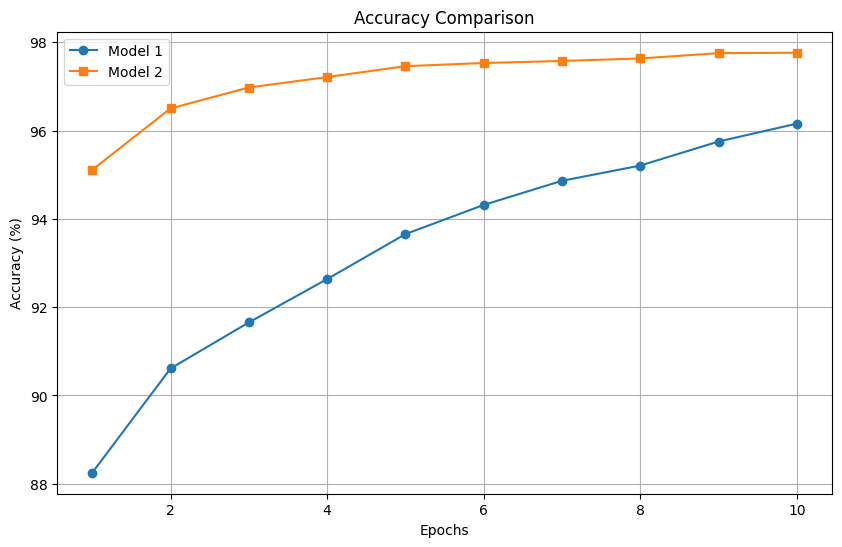

In [24]:
import matplotlib.pyplot as plt  # Import the matplotlib library if not already imported

epochs = range(1, len(accuracy_list["test"]) + 1)

# Plot accuracy for both lists
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_list["test"], label='Model 1', marker='o')
plt.plot(epochs, loss_list_KD["test"], label='Model 2', marker='s')

# Customize the plot
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
